## Setup

In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Dreadful horror sequel to "The Howling". This picks off with Karen White\'s funeral (she was killed at the end of the first film). Stefan Crosscoe (Christopher Lee sadly) arrives there and tells Karen\'s brother Ben (Reb Brown) that Karen was a werewolf. He\'s going to Transylvania to kill Striba (Sybil Danning) the head werewolf. Ben and a coworker of Karens (Annie McEnroe) join him.<br /><br />A terrible script, bad direction, inept editing and truly horrendous acting by Brown and McEnroe single handedly sink this one. The werewolf effects are mostly kept in the dark--for good reason! They\'re terrible when you see them. Subpar special effects also--although I DID like the cartoon lightning that comes from Danning\'s fingers. There\'s also a werewolf orgy which is particularly stupid and Danning takes off her top at least EIGHT TIMES during the closing credits! <br /><br />There are a few good things--I found the village in Transylvania amusing--it looks like it came from 

## Buat Teks Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

### Metode adapt mengatur kosakata lapisan. 20 token pertama

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 197, 768, ...,   0,   0,   0],
       [ 11,  20,   7, ...,   0,   0,   0],
       [ 13,  13,  48, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Dreadful horror sequel to "The Howling". This picks off with Karen White\'s funeral (she was killed at the end of the first film). Stefan Crosscoe (Christopher Lee sadly) arrives there and tells Karen\'s brother Ben (Reb Brown) that Karen was a werewolf. He\'s going to Transylvania to kill Striba (Sybil Danning) the head werewolf. Ben and a coworker of Karens (Annie McEnroe) join him.<br /><br />A terrible script, bad direction, inept editing and truly horrendous acting by Brown and McEnroe single handedly sink this one. The werewolf effects are mostly kept in the dark--for good reason! They\'re terrible when you see them. Subpar special effects also--although I DID like the cartoon lightning that comes from Danning\'s fingers. There\'s also a werewolf orgy which is particularly stupid and Danning takes off her top at least EIGHT TIMES during the closing credits! <br /><br />There are a few good things--I found the village in Transylvania amusing--it looks like it came fro

## Buat Model

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00901138]


In [15]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00901138]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

Epoch 1/10
391/391 [==============================] - 53s 108ms/step - loss: 0.6491 - accuracy: 0.5668 - val_loss: 0.5103 - val_accuracy: 0.7260
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4227 - accuracy: 0.8102 - val_loss: 0.3959 - val_accuracy: 0.8380
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3542 - accuracy: 0.8461 - val_loss: 0.3460 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3273 - accuracy: 0.8608 - val_loss: 0.3380 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3176 - accuracy: 0.8654 - val_loss: 0.3358 - val_accuracy: 0.8479
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3092 - accuracy: 0.8692 - val_loss: 0.3287 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3020 - accuracy: 0.8712 - val_loss: 0.3336 - val_accuracy

(0.0, 0.6667244836688042)

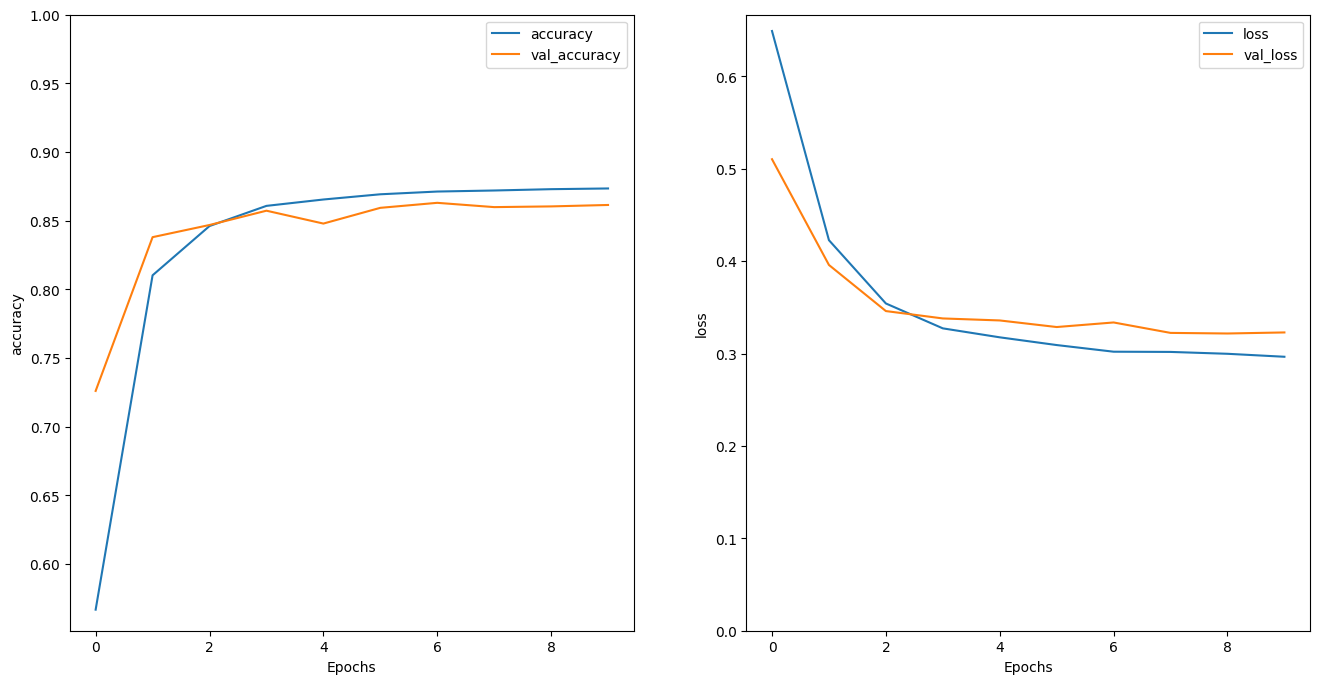

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 151ms/step - loss: 0.6243 - accuracy: 0.5977 - val_loss: 0.4858 - val_accuracy: 0.8094
Epoch 2/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3832 - accuracy: 0.8304 - val_loss: 0.3519 - val_accuracy: 0.8396
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3328 - accuracy: 0.8540 - val_loss: 0.3408 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3191 - accuracy: 0.8609 - val_loss: 0.3364 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 45s 113ms/step - loss: 0.3114 - accuracy: 0.8663 - val_loss: 0.3206 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3051 - accuracy: 0.8684 - val_loss: 0.3307 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3027 - accuracy: 0.8699 - val_loss: 0.3191 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 50ms/step - loss: 0.3143 - accuracy: 0.8554
Test Loss: 0.3142523765563965
Test Accuracy: 0.855400025844574


In [23]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8614873]]


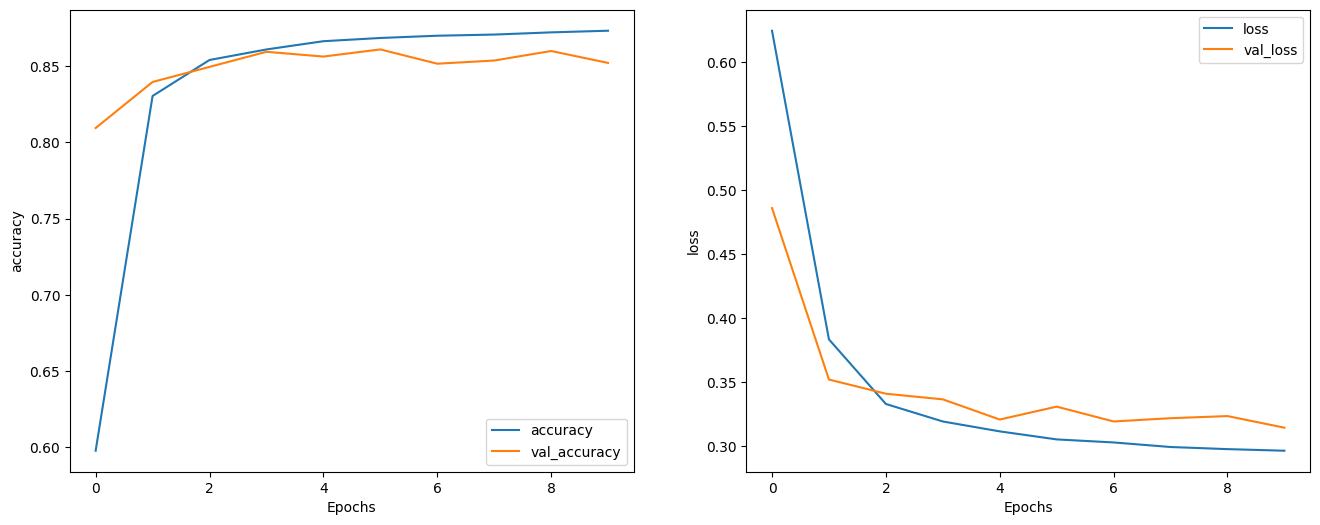

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')